Label(value='Goals Reached: 0', layout=Layout(width='auto'))

Label(value='Cancelled Goals: 0', layout=Layout(width='auto'))

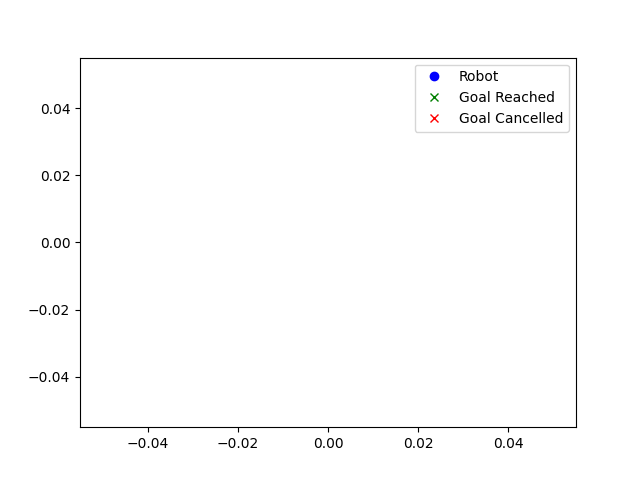

In [1]:
%matplotlib widget
import rospy
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from std_msgs.msg import String
import actionlib
import actionlib_msgs
import assignment_2_2022.msg
from my_package.msg import output_client 
from my_package.srv import target 
from geometry_msgs.msg import Twist, Pose, Point
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalID
import ipywidgets as widgets
import sys
import select
from matplotlib.animation import FuncAnimation

class Map:
    def __init__(self):
        
        # Intialize the plot
        self.fig, self.ax = plt.subplots()
        # Plot the robot's position
        self.robot_marker, = plt.plot([], [], 'bo', label='Robot')
        
        # Plot the goals reached and cancelled
        self.reached_marker, = self.ax.plot([], [], 'gx', label='Goal Reached')
        self.cancelled_marker, = self.ax.plot([], [], 'rx', label='Goal Cancelled')
        self.robot_x = 0.0
        self.robot_y = 0.0
        self.goals_reached = 0
        self.goals_cancelled = 0
        self.cancelled_x = []
        self.cancelled_y = []
        self.reached_x = []
        self.reached_y = []
        
        #Setting up the widgets 
        self.reached_widget = widgets.Label(value="Goals Reached: " + str(self.goals_reached), layout=widgets.Layout(width='auto'))
        self.cancelled_widget = widgets.Label(value="Cancelled Goals: " + str(self.goals_cancelled), layout=widgets.Layout(width='auto'))
        
        self.ax.legend()
        plt.ion()  
    
    def plot_init(self):
        # Set up the different parameters for the plot 
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_title('Robot Map')
        
      
        
    def odom_callback(self, msg):
        #Get the robot position
        self.robot_x = msg.pose.pose.position.x
        self.robot_y = msg.pose.pose.position.y
        
    def goal_callback(self, msg):
        #Get the position of the goal 
        self.goal_position_x = msg.goal.target_pose.pose.position.x
        self.goal_position_y = msg.goal.target_pose.pose.position.y
        self.current_goal = [self.goal_position_x, self.goal_position_y]

    def goal_status_callback(self, msg):
        # Check the status of the robot 
        status=msg.status.status
     
        # If status is 3, it means that a goal has been reached
        if status == 3: 
            self.reached_x.append(self.current_goal[0])
            self.reached_y.append(self.current_goal[1])
            self.goals_reached = self.goals_reached + 1
            
  
            
        # If the status is 2, it means that a goal has been cancelled.
        elif status == 2: 
            self.cancelled_x.append(self.current_goal[0])
            self.cancelled_y.append(self.current_goal[1])
            self.goals_cancelled = self.goals_cancelled + 1
            

        
    def update_plot(self, frame):
        self.robot_marker.set_data([self.robot_x], [self.robot_y])
        # Update the goals reached and cancelled
        self.reached_marker.set_data(self.reached_x, self.reached_y)
        self.cancelled_marker.set_data(self.cancelled_x, self.cancelled_y)
        self.cancelled_widget.value = "Cancelled Goals: " + str(self.goals_cancelled)
        self.reached_widget.value = "Goals Reached: " + str(self.goals_reached)
        
       

    


map_object = Map()
rospy.init_node('jupyter_client')

#Set up subscribers
rospy.Subscriber('/odom', Odometry, map_object.odom_callback)
rospy.Subscriber('/reaching_goal/result', assignment_2_2022.msg.PlanningActionResult, map_object.goal_status_callback)
rospy.Subscriber('/reaching_goal/goal', assignment_2_2022.msg.PlanningActionGoal, map_object.goal_callback)

#Display the map and widgets 
map_plot = FuncAnimation(map_object.fig, map_object.update_plot, init_func=map_object.plot_init,blit=True, cache_frame_data=False)
display(map_object.reached_widget)
display(map_object.cancelled_widget)
plt.show(block=False)

In [2]:
client = actionlib.SimpleActionClient("reaching_goal", assignment_2_2022.msg.PlanningAction)

# Define a callback function for the set goal button click event
def set_goal_button_click(b):
    # Initialize the action client
    x = x_input.value
    y = y_input.value
    print(f"Goal coordinates: x={x}, y={y}")
    try : 
    # Check if x and y are valid float values. 
        x = float (x)
        y = float (y)
    except ValueError:
        # If an error is raised, print this message.
        print (" Error, input was not a float number. Please input a number")
        # This will go back to the main loop without crashing the programm
        # That way the user can try to input another number
        return
    goal = assignment_2_2022.msg.PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    goal.target_pose.pose.orientation.w = 1.0
                
    # Send the goal to the server
    client.send_goal(goal)
    
   
def cancel_goal_button_click(b):
    cancel_msg = GoalID()
    cancel_pub.publish(cancel_msg)
    print("The goal was cancelled")

# Create FloatText widgets for x and y coordinates
x_input = widgets.FloatText(description='X:')
y_input = widgets.FloatText(description='Y:')

# Create buttons for setting goal, canceling goal
set_goal_button = widgets.Button(description='Set Goal')
cancel_goal_button = widgets.Button(description='Cancel Goal')


#client = actionlib.SimpleActionClient("reaching_goal", assignment_2_2022.msg.PlanningAction)
goal_id_pub = rospy.Publisher('/reaching_goal/goal', assignment_2_2022.msg.PlanningActionGoal, queue_size=10)
cancel_pub = rospy.Publisher('/reaching_goal/cancel', GoalID, queue_size=10)


# Register the callback functions to the respective button's on_click event
set_goal_button.on_click(set_goal_button_click)
cancel_goal_button.on_click(cancel_goal_button_click)


# Display the widgets
display(widgets.VBox([x_input, y_input, set_goal_button, cancel_goal_button]))


In [3]:
def scan_callback(msg):
    # Get the minimum distance
    distance = min(msg.ranges)
    distance_widget.value = "{:.2f}".format(distance)


rospy.Subscriber('/scan', LaserScan, scan_callback)
distance_widget = widgets.FloatText(description='Closest obstacle:', value=0.0, layout=widgets.Layout(width='200px'))

display(distance_widget)

FloatText(value=0.0, description='Closest obstacle:', layout=Layout(width='200px'))